## Neural Networks Learning

## Import

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import matplotlib.cm as cm              # Để hiển thị ảnh xám (greyscale)
import random
import scipy.optimize
import itertools
from scipy.special import expit         # expit(z) = 1 / (1 + exp(-z))

### 1 Neural Networks

#### 1.1 Visualizing the data

In [ ]:
!wget https://drive.google.com/uc?id=102_kmQwuJTzM25LaMIApb-Gcsh7hu06v -O ex3data1.mat
!ls

--2020-05-11 11:29:44--  https://drive.google.com/uc?id=102_kmQwuJTzM25LaMIApb-Gcsh7hu06v
Resolving drive.google.com (drive.google.com)... 142.250.98.100, 142.250.98.138, 142.250.98.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c0uf9au1fufoqeid0qjimr7j5ne1s8gk/1589196525000/15887727500078625857/*/102_kmQwuJTzM25LaMIApb-Gcsh7hu06v [following]
--2020-05-11 11:29:45--  https://doc-0s-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c0uf9au1fufoqeid0qjimr7j5ne1s8gk/1589196525000/15887727500078625857/*/102_kmQwuJTzM25LaMIApb-Gcsh7hu06v
Resolving doc-0s-b8-docs.googleusercontent.com (doc-0s-b8-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-0s-b8-docs.googleusercontent.com (doc-0s-b8-docs.googleusercontent.com)|172.2

In [ ]:
datafile = 'ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']
# Thêm cột 1
X = np.insert(X, 0, 1,axis=1)
print("'y' shape: %s. Unique elements in y: %s" % (mat['y'].shape, np.unique(mat['y'])))
print("'X' shape: %s. X[0] shape: %s" % (X.shape, X[0].shape))
# X là ma trận chứa 5000 ảnh, mỗi ảnh là 1 dòng gồm 400 (20x20) phần tử tương ứng với số pixel của ảnh.
# y chứa các nhãn từ 1-10, "10" tương ứng với chữ số "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [ ]:
# Chuyển đổi ảnh đã được "duỗi" (1x400) thành ảnh 20x20
def getDatumImg(row):
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

# Lấy 100 ảnh ngẫu nhiên từ tập dữ liệu, hiển thị dưới dạng lưới 10x10    
def displayData(indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows * ncols)
        
    big_picture = np.zeros((height * nrows, width * ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow * height : irow * height + iimg.shape[0], icol * width : icol * width + iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture, cmap = cm.Greys_r)

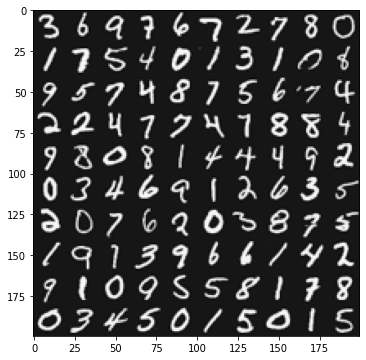

In [ ]:
displayData()

#### 1.2 Model representation

<img src="https://i.imgur.com/YylFf6Q.png" height="400">

Tải các trọng số (weight) của mô hình đã train sẵn về máy bằng cách chạy cell dưới đây.

Đối với các bạn chạy trên máy cục bộ thay vì Colab: sử dụng link trong cell dưới đây để download file trọng số về máy.

In [ ]:
!wget https://drive.google.com/uc?id=1kTsE2hcPFMST09dE3sIX2-zaaIJ4VREP -O ex3weights.mat
!ls

--2020-05-11 11:29:53--  https://drive.google.com/uc?id=1kTsE2hcPFMST09dE3sIX2-zaaIJ4VREP
Resolving drive.google.com (drive.google.com)... 74.125.31.101, 74.125.31.138, 74.125.31.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.31.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l68obt8r5smola79vpe1occ53s5kmuvs/1589196525000/15887727500078625857/*/1kTsE2hcPFMST09dE3sIX2-zaaIJ4VREP [following]
--2020-05-11 11:29:53--  https://doc-0k-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l68obt8r5smola79vpe1occ53s5kmuvs/1589196525000/15887727500078625857/*/1kTsE2hcPFMST09dE3sIX2-zaaIJ4VREP
Resolving doc-0k-b8-docs.googleusercontent.com (doc-0k-b8-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-0k-b8-docs.googleusercontent.com (doc-0k-b8-docs.googleusercontent.com)|172.217.2

In [ ]:
# Các trọng số (Θ(1),Θ(2)) 
# tương ứng với các cột theta1 và theta2 trong ex3weights.mat
datafile = 'ex3weights.mat'
mat = scipy.io.loadmat(datafile)
theta1, theta2 = mat['Theta1'], mat['Theta2']
print("theta1 has shape:", theta1.shape)
print("theta2 has shape:", theta2.shape)

theta1 has shape: (25, 401)
theta2 has shape: (10, 26)


In [ ]:
# Các hyperparameters
input_layer_size = 400              # Số nơron lớp input
hidden_layer_size = 25              # Số nơron lớp ẩn
output_layer_size = 10              # Số nơron lớp output
n_training_samples = X.shape[0]     # Số mẫu
max_iteration = 50                  # Số vòng lặp trong huấn luyện

In [ ]:
# Duỗi các ma trận theta thành 1 ma trận có cỡ (n, 1)
def flattenParams(thetas_list):
    flattened_list = [myTheta_.flatten() for myTheta_ in thetas_list]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size + 1) * hidden_layer_size + \
                            (hidden_layer_size + 1) * output_layer_size
    return np.array(combined).reshape((len(combined),1))

# Phục hồi ma trận đã được duỗi về nguyên trạng ban đầu
def reshapeParams(flattened_array):
    theta1_ = flattened_array[:(input_layer_size + 1) * hidden_layer_size] \
            .reshape((hidden_layer_size, input_layer_size + 1))
    theta2_ = flattened_array[(input_layer_size + 1) * hidden_layer_size:] \
            .reshape((output_layer_size, hidden_layer_size + 1))
    return [theta1_, theta2_]

# Duỗi X
def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples * (input_layer_size + 1), 1))

# Phục hồi X từ ma trận đã duỗi
def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples, input_layer_size + 1))

#### 1.3 Feedforward and cost function

Hàm cost:

<img src="https://i.imgur.com/483ZKV8.png" height="70">

Hàm cost với regularization:

<img src="https://i.imgur.com/fQzNLmg.png" height="120">

In [ ]:
# Nhận ma trận duỗi theta (bao gồm bias), ma trận duỗi X 
# và ma trận y làm tham số
# Duyệt qua mỗi mẫu dữ liệu, đồng thời:
# 1. Xây dựng một ma trận / vectơ đầu ra (y_h) cỡ (10, 1)
# với chỉ một giá trị khác 0 tương ứng với mẫu dữ liệu đó
# 2. Tính cost cho trường hợp vừa duyệt
# 3. Tính cost cho cả bộ dữ liệu
# 4. Tính giá trị regularization
def computeCost(myThetas_flattened, myX_flattened, myy, myLambda=0.): 
    # Phục hồi theta và X về nguyên trạng
    myThetas_ = reshapeParams(myThetas_flattened)
    myX = reshapeX(myX_flattened)
    
    # Cost của toàn bộ dữ liệu
    total_cost = 0.
    
    m = n_training_samples

    # Duyệt qua từng mẫu dữ liệu (từng dòng trong X, bao gồm cả bias)
    for irow in range(m):
        myrow = myX[irow]
        
        # Tính hypothesis (vectơ cỡ (10, 1) chỗ mỗi mẫu dữ liệu
        # Phương thức propagateForward trả lại cặp (z, a) cho mỗi lớp 
        # trong mạng nơron, propagateforward[-1][1] lấy ra giá trị a
        # của lớp output
        myhs = propagateForward(myrow, myThetas_)[-1][1]

        # Xây dựng vectơ y với chỉ 1 giá trị bằng 1 / khác 0 (one-hot)
        # Riêng trường hợp giá trị thứ 10 bằng 1 sẽ tương ứng với chữ số "0"
        tmpy  = np.zeros((10,1))
        tmpy[myy[irow] - 1] = 1
        
        # Tính cost cho trường hợp này
        mycost = -tmpy.T.dot(np.log(myhs)) - (1 - tmpy.T).dot(np.log(1 - myhs))
     
        # Tính tổng các cost
        total_cost += mycost
  
    # Normalize giá trị total_cost
    total_cost = float(total_cost) / m
    
    # Tính giá trị regularization
    total_reg = 0.
    for myTheta_ in myThetas_:
        total_reg += np.sum(myTheta_ * myTheta_)
    total_reg *= float(myLambda) / (2 * m)
        
    return total_cost + total_reg
       
# Lan truyền thuận / tiến
# Lan truyền vectơ đặc trưng lần lượt qua các lớp của mạng nơron
# Output lần lượt là cặp vectơ (z, a) của lớp ẩn và (z, a) của lớp output
# Thêm bias giữa các lớp
def propagateForward(row, thetas_):
    features = row
    zs_as_per_layer = []
    for i in range(len(thetas_)):  
        theta_ = thetas_[i]
        z = theta_.dot(features).reshape((theta_.shape[0], 1))
        a = expit(z)
        zs_as_per_layer.append((z, a))
        if i == len(thetas_) - 1:
            return np.array(zs_as_per_layer)
        a = np.insert(a, 0, 1)
        features = a

In [ ]:
# Với các trọng số thetas cho sẵn, giá trị cost là ~0.287629
myThetas = [theta1, theta2]

print(computeCost(flattenParams(myThetas), flattenX(X), y))

0.2876291651613187


#### 1.4 Regularized cost function

In [ ]:
# Với lambda = 1, giá trị cost là ~0.383770
myThetas = [theta1, theta2]
print(computeCost(flattenParams(myThetas), flattenX(X), y, myLambda=1.))

0.38448779624289375


### 2 Backpropagation

#### 2.1 Sigmoid gradient

<img src="https://i.imgur.com/3FWOWCn.png" height="50">

với

<img src="https://i.imgur.com/1tEfaAQ.png" height="40">

In [ ]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy * (1 - dummy)

#### 2.2 Random initialization

Tạo ra các trọng số theta ngẫu nhiên

In [ ]:
def genRandthetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size + 1)
    theta2_shape = (output_layer_size, hidden_layer_size + 1)
    rand_thetas = [np.random.rand(*theta1_shape) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand(*theta2_shape) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 Backpropagation

<img src="https://i.imgur.com/P8fLI2n.png" height="400">


**Thuật toán lan truyền ngược**

1. Thực hiện lần lan truyền thuận đầu tiên, tính giá trị activation $a$ ở các lớp 2 (ẩn) và 3 (output).

2. Với mỗi nơron k ở lớp output: 

<img src="https://i.imgur.com/z81Ocsd.png" height="40">

$y_k\in\{0,1\}$ chỉ xem mẫu hiện tại có tương ứng với chữ số $k$ ($y_k=1$) hay chữ số khác ($y_k=0$)

3. Với lớp ẩn ($l=2$):

<img src="https://i.imgur.com/GQO9pqh.png" height="40">

4. Tính gradient:

<img src="https://i.imgur.com/LJRUWZc.png" height="35">

5. Tính gradient cho hàm cost của mô hình từ gradient từng mẫu:

<img src="https://i.imgur.com/S8Wb7RS.png" height="65">



In [ ]:
# Lan truyền ngược
def backPropagate(myThetas_flattened, myX_flattened, myy, myLambda=0.):
    # Phục hồi theta và X về nguyên trạng
    myThetas_ = reshapeParams(myThetas_flattened)   
    myX = reshapeX(myX_flattened)

    # Ma trận delta chứa bias, có cùng cỡ với ma trận theta
    D1 = np.zeros((hidden_layer_size, input_layer_size + 1))
    D2 = np.zeros((output_layer_size, hidden_layer_size + 1))

    # Duyệt qua từng mẫu dữ liệu (từng dòng trong X, bao gồm cả bias)
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size + 1, 1))
        # Phương thức propagateForward trả lại cặp (z, a) cho mỗi lớp 
        # trong mạng nơron, trừ lớp input
        temp = propagateForward(myrow, myThetas_)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10, 1))
        tmpy[myy[irow]-1] = 1
        delta3 = a3 - tmpy 
        delta2 = myThetas_[1].T[1:, :].dot(delta3) * sigmoidGradient(z2)
        a2 = np.insert(a2, 0, 1, axis=0)
        D1 += delta2.dot(a1.T) # (25, 1) x (1, 401) = (25, 401)
        D2 += delta3.dot(a2.T) # (10, 1) x (1, 25) = (10, 25)
        
    D1 = D1 / float(m)
    D2 = D2 / float(m)
    
    # Regularization
    D1[:, 1:] = D1[:, 1:] + (float(myLambda) / m) * myThetas_[0][:, 1:]
    D2[:, 1:] = D2[:, 1:] + (float(myLambda) / m) * myThetas_[1][:, 1:]
    
    return flattenParams([D1, D2]).flatten()

In [ ]:
# Tính ma trận D dựa vào theta
D1D2_flattened = backPropagate(flattenParams(myThetas), flattenX(X), y, myLambda=0.)
D1, D2 = reshapeParams(D1D2_flattened)

#### 2.4 Gradient checking

In [ ]:
def checkGradient(myThetas_, myDs, myX, myy, myLambda=0.):
    myeps = 0.0001
    flattened = flattenParams(myThetas_)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    # Lấy ngẫu nhiên 10 phần tử, tính gradient và so sánh với D
    for i in range(10):
        x = int(np.random.rand() * n_elems)
        epsvec = np.zeros((n_elems, 1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec, myX_flattened, myy, myLambda)
        cost_low  = computeCost(flattened - epsvec, myX_flattened, myy, myLambda)
        mygrad = (cost_high - cost_low) / float(2 * myeps)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x, mygrad, flattenedDs[x]))

In [ ]:
checkGradient(myThetas, [D1,  D2], X, y)

Element: 9958. Numerical Gradient = -0.000036. BackProp Gradient = -0.000036.
Element: 2146. Numerical Gradient = -0.000001. BackProp Gradient = -0.000001.
Element: 3835. Numerical Gradient = -0.000054. BackProp Gradient = -0.000054.
Element: 3364. Numerical Gradient = -0.000037. BackProp Gradient = -0.000037.
Element: 7264. Numerical Gradient = 0.000124. BackProp Gradient = 0.000124.
Element: 7692. Numerical Gradient = 0.000012. BackProp Gradient = 0.000012.
Element: 7419. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 3757. Numerical Gradient = 0.000072. BackProp Gradient = 0.000072.
Element: 68. Numerical Gradient = -0.000052. BackProp Gradient = -0.000052.
Element: 761. Numerical Gradient = -0.000001. BackProp Gradient = -0.000001.


#### 2.5 Learning parameters using fmincg

In [ ]:
# Sinh ngẫu nhiên ma trận trọng số theta, tối ưu rồi trả lại theta
def trainNN(myLambda=0.):
    randomthetas_unrolled = flattenParams(genRandthetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomthetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X), y, myLambda), maxiter=max_iteration, disp=True, full_output=True)
    return reshapeParams(result[0])

In [ ]:
# Quá trình huấn luyện nhanh hay chậm tùy thuộc vào hiệu năng của CPU
learned_thetas = trainNN()

         Current function value: 0.284367
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111


In [ ]:
# Sử dụng propagateForward để dự đoán nhãn
def predictNN(row, thetas_):
    classes = list(range(1, 10)) + [10]
    output = propagateForward(row, thetas_)
    # Lấy giá trị a [1] của lớp cuối cùng [-1]
    return classes[np.argmax(output[-1][1])] 

# Duyệt qua từng mẫu dữ liệu trong X và dự đoán nhãn (chữ số) dựa vào các trọng
# số theta. Tính độ chính xác từ số nhãn dự đoán đúng.
def computeAccuracy(myX, myThetas_, myy):
    n_correct,  n_total = 0,  myX.shape[0]
    for irow in range(n_total):
        if int(predictNN(myX[irow], myThetas_)) == int(myy[irow]): 
            n_correct += 1
    print("Training set accuracy: %0.1f%%" % (100 * (float(n_correct) / n_total)))

In [ ]:
# Độ chính xác ~95%, có thể chênh lệch ít nhiều do trọng số theta được sinh ngẫu nhiên
computeAccuracy(X, learned_thetas, y)

Training set accuracy: 96.7%


In [ ]:
# Thử gán lambda = 10
learned_regularized_thetas = trainNN(myLambda=10.)

         Current function value: 1.077337
         Iterations: 50
         Function evaluations: 120
         Gradient evaluations: 120


In [ ]:
computeAccuracy(X, learned_regularized_thetas, y)

Training set accuracy: 93.1%


### 3 Visualizing the hidden layer

Hiển thị lớp ẩn

In [ ]:
# Lấy lớp theta đầu tiên (từ lớp input -> lớp ẩn), loại bỏ bias và chuyển
# đổi thành ma trận 20x20 rồi hiển thị kết quả
def displayHiddenLayer(myTheta_):
    # Loại bỏ bias
    myTheta_ = myTheta_[:, 1:]
    assert myTheta_.shape == (25, 400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow,  icol = 0, 0
    for row in myTheta_:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(np.insert(row, 0, 1))
        big_picture[irow * height : irow * height + iimg.shape[0], icol * width : icol * width + iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture, cmap = cm.Greys_r)

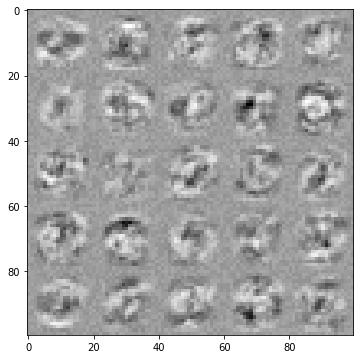

In [ ]:
displayHiddenLayer(learned_thetas[0])